### import modules

In [11]:
import logging
import os
import time

from pytorch_lightning.callbacks import ModelCheckpoint, BatchSizeFinder
from pytorch_lightning.loggers import NeptuneLogger, TensorBoardLogger
import neptune.new as neptune
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import RichProgressBar
import yaml

from src.data import dataset
from src.utils import callbacks
from src.wakegan import WakeGAN

torch.set_float32_matmul_precision("medium")

### import config file

In [12]:
with open("config.yaml") as file:
    config = yaml.safe_load(file)

### initialize neptune client

In [13]:
neptune_logger = None
if config["ops"]["neptune_logger"]:
    neptune_logger = NeptuneLogger(
        project="idatha/wakegan",
        api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyNWQ5YjJjZi05OTE1LTRhNWEtODdlZC00MWRlMzMzNGMwMzYifQ==",
        log_model_checkpoints=False,
    )

### add config content as hyperparameters in neptune

In [14]:
if config["ops"]["neptune_logger"]:
    neptune_logger.log_hyperparams(params=config)

https://app.neptune.ai/idatha/wakegan/e/WAK-188
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


### config custom loggers

In [15]:
tb_logger = TensorBoardLogger(save_dir="logs/")
if "logs" not in os.listdir("."):
    os.mkdir("logs")
logging.basicConfig(
    format="%(message)s",
    filename=os.path.join("logs", "train.log"),
    level=logging.INFO,
    filemode="w",
)
logger = logging.getLogger("train")
loggers = (
    [tb_logger, neptune_logger] if config["ops"]["neptune_logger"] else [tb_logger]
)

### configure checkpoint model saving

In [16]:
checkpoint_callback = ModelCheckpoint(
    dirpath=None,
    save_top_k=1,
    monitor="rmse_val_epoch",
    mode="min",
    filename="wakegan-{epoch}-{rmse_val_epoch:.2f}",
)

### initialize training dataset

In [17]:
dataset_train = dataset.WakeGANDataset(
    data_dir=os.path.join("data", "preprocessed", "tracked", "train"),
    config=config["data"],
    dataset_type="train",
    save_norm_params=True if config["models"]["save"] else False,
)
datamodule = dataset.WakeGANDataModule(config)

### initialize model

In [18]:
model = WakeGAN(config, dataset_train.norm_params)

### initialize trainer

In [19]:
trainer = pl.Trainer(
    default_root_dir="logs",
    accelerator="gpu",
    devices=1,
    log_every_n_steps=1,
    max_epochs=config["train"]["num_epochs"],
    logger=loggers,
    deterministic=True,
    callbacks=[
        callbacks.LoggingCallback(logger),
        callbacks.PlottingCallback(enable_logger=config["ops"]["neptune_logger"]),
        checkpoint_callback,
        RichProgressBar()
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### fit model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                     ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ generator     │ Generator                │  9.7 M │
│ 1 │ discriminator │ Discriminator            │  940 K │
│ 2 │ mse_train     │ MeanSquaredError         │      0 │
│ 3 │ mse_val       │ MeanSquaredError         │      0 │
│ 4 │ mse_test      │ MeanSquaredError         │      0 │
│ 5 │ fid_train     │ FrechetInceptionDistance │ 23.9 M │
│ 6 │ fid_val       │ FrechetInceptionDistance │ 23.9 M │
│ 7 │ fid_test      │ FrechetInceptionDistance │ 23.9 M │
└───┴───────────────┴──────────────────────────┴────────┘

Trainable params: 10.7 M                                                                                           
Non-trainable params: 71.6 M                                                                                       
Total params: 82.2 M                                                                                               
Total estimated model params size (MB): 328

Output()

`Trainer.fit` stopped: `max_epochs=3` reached.


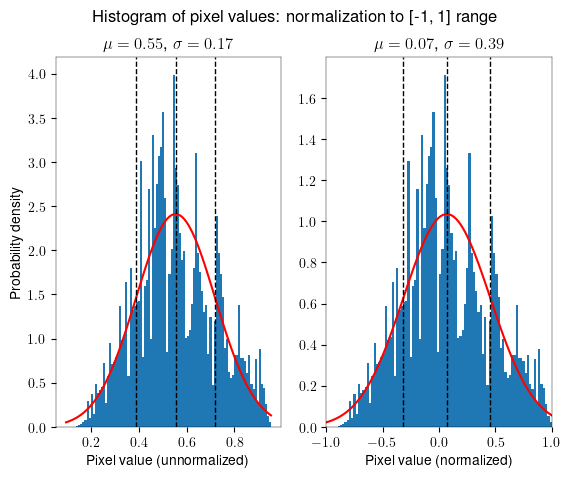

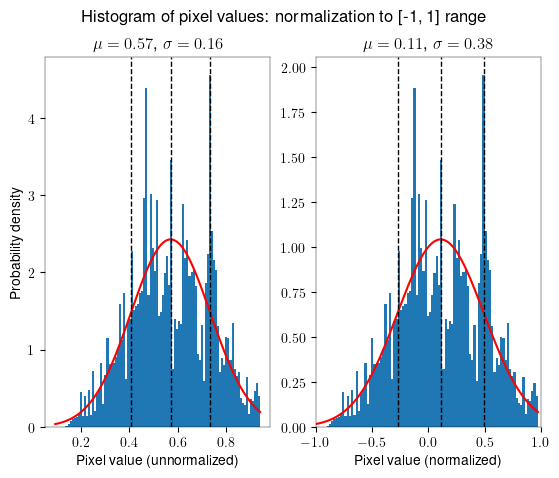

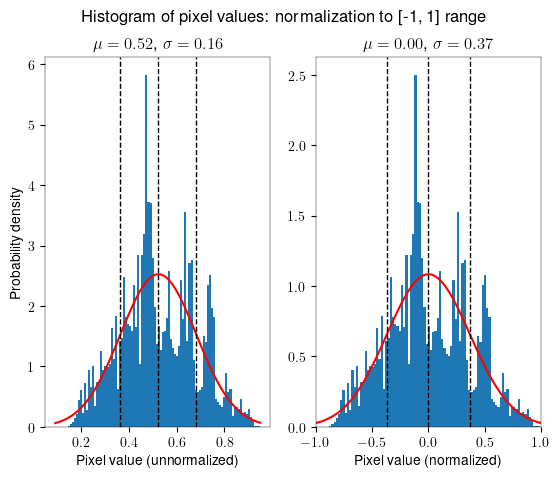

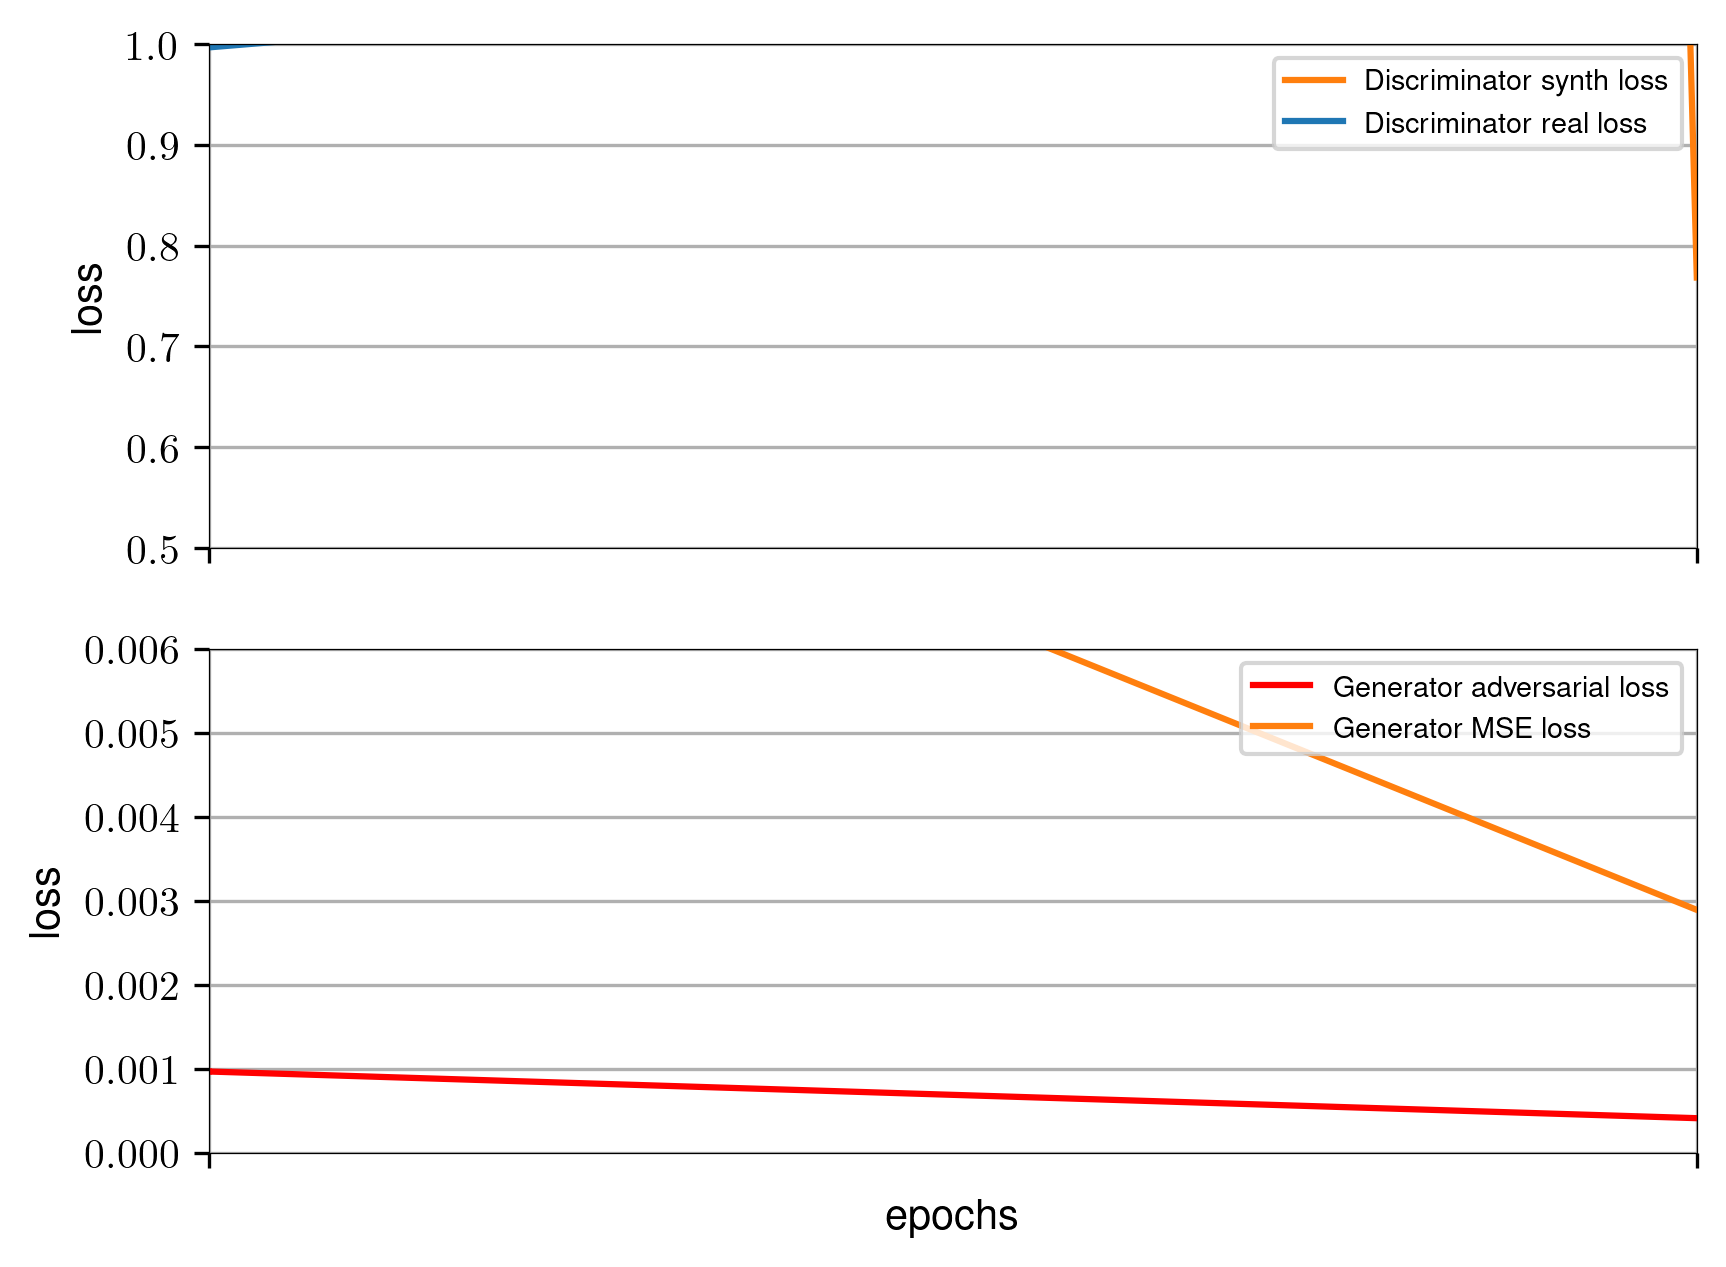

Unexpected error occurred in Neptune background thread: Killing Neptune asynchronous thread. All data is safe on disk and can be later synced manually using `neptune sync` command.


Exception in thread NeptuneAsyncOpProcessor:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/max/Documents/wakeGAN/.venv_wakegan/lib/python3.10/site-packages/neptune/new/internal/operation_processors/async_operation_processor.py", line 226, in run
    super().run()
  File "/home/max/Documents/wakeGAN/.venv_wakegan/lib/python3.10/site-packages/neptune/new/internal/threading/daemon.py", line 53, in run
    self.work()
  File "/home/max/Documents/wakeGAN/.venv_wakegan/lib/python3.10/site-packages/neptune/new/internal/operation_processors/async_operation_processor.py", line 242, in work
    self.process_batch([element.obj for element in batch], batch[-1].ver)
  File "/home/max/Documents/wakeGAN/.venv_wakegan/lib/python3.10/site-packages/neptune/new/internal/threading/daemon.py", line 76, in wrapper
    result = func(self_, *args, **kwargs)
  File "/home/max/Documents/wakeGAN/.venv_wakegan/lib/python3.

In [20]:
trainer.fit(model, datamodule)

### save new model version (best checkpoint) to neptune

In [ ]:
if config["ops"]["neptune_logger"] and config["models"]["save"]:
    logger.info("Saving model in neptune")

    import neptune.new as neptune

    model_version = neptune.init_model_version(
        model="WAK-MOD",
        project="idatha/wakegan",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyNWQ5YjJjZi05OTE1LTRhNWEtODdlZC00MWRlMzMzNGMwMzYifQ==",  # your credentials
    )
    path_to_model = trainer.checkpoint_callback.best_model_path
    model_version["model/ckpt"].upload(path_to_model)
    model_version["model/dataset/training"].track_files(
        os.path.join("data", "preprocessed", "tracked", "train", "ux")
    )
    model_version["model/dataset/validation"].track_files(
        os.path.join("data", "preprocessed", "tracked", "val", "ux")
    )
    model_version["model/dataset/testing"].track_files(
        os.path.join("data", "preprocessed", "tracked", "test", "ux")
    )
    model_version["model/run"] = neptune_logger.run["sys/id"].fetch()
    model_version.change_stage("staging")